# MNIST dataset
> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)) and 
Mikkel Vilstrup ([mvilstrup](https://github.com/MVilstrup)).
</span>

In this notebook we will guide you through building a neural network classifier for the (in)famous MNIST dataset.
MNIST is a dataset that is often used for benchmarking, consisting of 70.000 image-label paris of handwritten digits from 0-9.
During the notebook we have provided a program skeleton and severalt tips to help guid you through it.
Further more the task is quite similar to what you did in the previous notebook, so you should reffer to it in order to remind yourself about the implementation.

Along the way you will also learn about 
* selecting nonlinearity, and
* stochastic gradient descent with mini-batches.

We will implement a dense feedforward neural network (just like before).
In this setting we represent each image as a vector, instead of a 2D map.
We therefore lose the spatial information of the images.
The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance.
This task is therefore called the _permutation invariant_ MNIST.
Obviously this throws away a lot of structure in the data that could have been used.
Later we will see how spatial information can be included, by using the convolutional neural network architecture.


## Implementation Rules

In this exercise we want you to get some experience with setting up training for yourself, and we therefore want you to implement the training loop yourself.
You are therefore **NOT** allowed to use the `keras.models.Sequential.fit` function.
The `Sequential` model, or built in layers, such as `keras.layers.Dense` are allowed, as long as you define the training ops and training loop yourself.
(If are having problems using `keras.layers` have a look at the [Keras as a simplified interface to TensorFlow](https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html) tutorial).


In [1]:
from __future__ import absolute_import, division, print_function 

import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils
import tensorflow as tf
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## The MNIST dataset
The 70,000 images-label pairs are split into a 
* 55,000 images training set, 
* 5,000 images validation set and 
* 10,000 images test set.

The images are 28x28 pixels, where each pixel represents the light intensity normalised value between 0-1 (0=black, 1=white).
The number of features is therefore 28x28=784.

First let's load the MNIST dataset and plot a few examples. TensorFlow has a [convenient MNIST interface](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) that we will use to download and manage the data.

In [2]:
# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32' # rescale images to `[0, 1]`
                                      )

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Information on dataset
----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 784
Image type		 <class 'numpy.float32'>
Image min/max value	 0.0 / 1.0
Label shape		 10
Label type		 <class 'numpy.float64'>


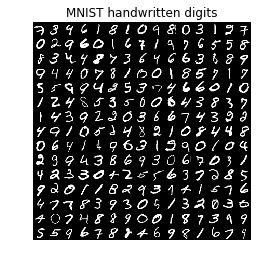

In [3]:
## Print dataset statistics and visualize
print("""Information on dataset
----------------------""")
print("Training size:\t", mnist_data.train.num_examples)
print("Test size\t", mnist_data.test.num_examples)
print("Validation size\t", mnist_data.validation.num_examples)

num_features = mnist_data.train.images[0].shape[0]
num_classes = mnist_data.train.labels[0].shape[0]

print('\nData summaries')
print("Image shape\t\t", num_features)
print("Image type\t\t", type(mnist_data.train.images[0][0]))
print("Image min/max value\t", np.min(mnist_data.train.images), '/', np.max(mnist_data.train.images))
print("Label shape\t\t", num_classes)
print("Label type\t\t", type(mnist_data.train.labels[0][0]))


## Plot a few MNIST examples
img_to_show = 15
idx = 0
canvas = np.zeros((28*img_to_show, img_to_show*28))
for i in range(img_to_show):
    for j in range(img_to_show):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = mnist_data.train.images[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()


## Creating the graph

#### <span style="color:red"> EXE 1) Defining the network
</span>

In the cell below, at the place that says `### YOUR CODE HERE ###` implement the following:

* Define two layers. Remember to give them proper names.
    * Try some different nonlinearities, and compare their performance
* The non-linearity of the output layer should be softmax ([tf.nn.softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax))


In [4]:
## Build the network
tf.reset_default_graph()

## Define placeholders
x_pl = tf.placeholder(tf.float32, [None, num_features], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
# Depending on your implementation you might need to cast y_pl differently
y_pl = tf.cast(y_pl, tf.float32)

## Define the model

### YOUR CODE HERE ###
# Network parameters:
weight_initializer = tf.truncated_normal_initializer(stddev=0.1)
num_units_l_2 = 100

# Network creation:
with tf.variable_scope('layer1'): 
    W_1 = tf.get_variable('W', [num_features, num_units_l_2], 
                          initializer=weight_initializer)
    b_1 = tf.get_variable('b', [num_units_l_2],
                          initializer=tf.constant_initializer(0.0))
    with tf.variable_scope('output'):
        
        l_1 = tf.matmul(x_pl, W_1) + b_1
        # RELU non-linearity
        l_1 = tf.nn.relu(l_1)
        
with tf.variable_scope('layer2'):
    W_2 = tf.get_variable('W', [num_units_l_2, num_classes],
                         initializer=weight_initializer)
    b_2 = tf.get_variable('b', [num_classes],
                         initializer=tf.constant_initializer(0.0))
    with tf.variable_scope('output'):
        l_2 = tf.matmul(l_1, W_2) + b_2
        
y_out = tf.nn.softmax(l_2)

#### <span style="color:red"> EXE 2) Defining the training operations.
</span>

In the cell below, at the place that says `### YOUR CODE HERE ###` implement the following:

* Cross_entropy loss
* An optimizer and training op
* An op computing the accuracy

In [5]:
### Implement training ops

### YOUR CODE HERE ###
#y_ = tf.placeholder(tf.float32, [None, num_classes], name='yPlaceholder')

# 1) Define cross entropy loss
with tf.variable_scope('loss'):
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y_out), reduction_indices=[1])
    cross_entropy = tf.reduce_mean(cross_entropy)
    
# 2) Define the training op
with tf.variable_scope('trainOP'):
#    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
    train_op = optimizer.minimize(cross_entropy)
    
# 3) Define accuracy op
with tf.variable_scope('accuracyOP'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y_pl, axis=1), tf.argmax(y_out, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



### Stochastic gradient descent with mini-batches

In the last notebook we used the entire dataset to compute every parameter update.
For large datasets this is very costly and inefficient.
Instead we can compute the gradient on only a small subset of the data, a *mini-batches*, and use it to update the parameters.
Bath size varies a lot depending on application but between 8-256 is common.
Bigger is not allways better.
With smaller mini-batch size you get more updates and your model might converge faster.
Also small batchsizes uses less memory -> freeing up memory so you train a model with more parameters.

#### <span style="color:red"> EXE 3) Testing the forward pass
</span>

Before building the training loop lets ensure that the forward pass works.

In the cell below, at the place that says `### YOUR CODE HERE ###` implement the following:

* define the `feed_dict`
* pass `x` through the network using `sess.run`

In [6]:
#Test the forward pass
batch_size = 32

# Get a mini-batch
x, y = mnist_data.train.next_batch(batch_size)

# Restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    sess.run(tf.global_variables_initializer())
    
    ### YOUR CODE HERE ###
    #Labels are already one-hot encoded from import
    feed_dict = {x_pl : x}
#    feed_dict = {x_pl : x, y_pl : utils.onehot(y, num_classes)}
    y_pred = sess.run(fetches=y_out, feed_dict=feed_dict)

#print(y_pred)
        
assert y_pred.shape == y.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

# Build the training loop.
We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches.
Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples.
The paramters are updated after each mini batch.
Networks converges much faster using minibatches because the paramters are updated more often.



#### <span style="color:red"> EXE 4) Building the training loop.
</span>

In the cell below, at the place that says `### YOUR CODE HERE ###` implement the following:

* Perform the training operation
* Collect training statistics
* [Optional] Monitor training in TensorBoard.

In [62]:
max_epochs = 200

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
#To save the trained network
saver = tf.train.Saver()

train_cost, val_cost, train_acc, val_acc = [],[],[],[]
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    try:
        sess.run(tf.global_variables_initializer())
        mnist_data.train._epochs_completed = 0
        while mnist_data.train.epochs_completed < max_epochs:
            # Load one mini-batch
            x, y = mnist_data.train.next_batch(batch_size)
            x_val, y_val = mnist_data.validation.next_batch(batch_size)
            ### YOUR CODE HERE ###
            feed_dict = {x_pl : x, y_pl : y}
            #print(type(y[0][0]))
            feed_dict_valid = {x_pl: x_val, y_pl: y_val}
            #feed_dict = {x_pl : x, y_pl : utils.onehot(y, num_classes)}
            # 1) Run the train op
            fetches_train = [train_op, cross_entropy, accuracy]
            y_pred = sess.run(fetches=fetches_train, feed_dict=feed_dict)
            # 2) Compute train_cost, val_cost, train_acc, val_acc
            train_cost += [y_pred[1]]
            train_acc += [y_pred[2]]
            fetches_valid = [cross_entropy, accuracy]
            y_pred_val = sess.run(fetches_valid, feed_dict_valid)
            val_cost += [y_pred_val[0]]
            val_acc += [y_pred_val[1]]
            # 3) Print training summaries
            #if mnist_data.train.epochs_completed % 10 == 0:
            print("Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f\t Train acc: %0.3f\t Val acc: %0.3f" \
                  %(mnist_data.train.epochs_completed, train_cost[-1],val_cost[-1],train_acc[-1],val_acc[-1]))
            mnist_data.train._epochs_completed += 1

        #End of training, saving the network
        saver.save(sess, 'trained_network')
        print('Network Saved !')
        print()
    except KeyboardInterrupt:
        print('KeyboardInterrupt')

print('Done')


Epoch 0, Train Cost: 2.385	Val Cost: 2.317	 Train acc: 0.156	 Val acc: 0.250
Epoch 1, Train Cost: 2.281	Val Cost: 2.229	 Train acc: 0.250	 Val acc: 0.125
Epoch 2, Train Cost: 2.281	Val Cost: 2.256	 Train acc: 0.250	 Val acc: 0.156
Epoch 3, Train Cost: 2.250	Val Cost: 2.046	 Train acc: 0.250	 Val acc: 0.438
Epoch 4, Train Cost: 2.127	Val Cost: 2.178	 Train acc: 0.312	 Val acc: 0.094
Epoch 5, Train Cost: 2.091	Val Cost: 2.170	 Train acc: 0.250	 Val acc: 0.219
Epoch 6, Train Cost: 2.118	Val Cost: 1.860	 Train acc: 0.312	 Val acc: 0.438
Epoch 7, Train Cost: 2.159	Val Cost: 2.012	 Train acc: 0.250	 Val acc: 0.375
Epoch 8, Train Cost: 2.053	Val Cost: 1.929	 Train acc: 0.250	 Val acc: 0.375
Epoch 9, Train Cost: 2.009	Val Cost: 1.895	 Train acc: 0.344	 Val acc: 0.469
Epoch 10, Train Cost: 1.910	Val Cost: 1.913	 Train acc: 0.469	 Val acc: 0.438
Epoch 11, Train Cost: 1.780	Val Cost: 1.644	 Train acc: 0.500	 Val acc: 0.531
Epoch 12, Train Cost: 1.825	Val Cost: 1.775	 Train acc: 0.469	 Val acc: 0.

Epoch 143, Train Cost: 0.546	Val Cost: 0.463	 Train acc: 0.844	 Val acc: 0.906
Epoch 144, Train Cost: 0.629	Val Cost: 0.574	 Train acc: 0.875	 Val acc: 0.812
Epoch 145, Train Cost: 0.648	Val Cost: 0.425	 Train acc: 0.844	 Val acc: 0.969
Epoch 146, Train Cost: 0.349	Val Cost: 0.639	 Train acc: 0.875	 Val acc: 0.844
Epoch 147, Train Cost: 0.402	Val Cost: 0.274	 Train acc: 0.875	 Val acc: 0.938
Epoch 148, Train Cost: 0.554	Val Cost: 0.499	 Train acc: 0.781	 Val acc: 0.844
Epoch 149, Train Cost: 0.427	Val Cost: 0.619	 Train acc: 0.781	 Val acc: 0.875
Epoch 150, Train Cost: 0.536	Val Cost: 0.279	 Train acc: 0.844	 Val acc: 0.938
Epoch 151, Train Cost: 0.745	Val Cost: 0.671	 Train acc: 0.875	 Val acc: 0.812
Epoch 152, Train Cost: 0.726	Val Cost: 0.587	 Train acc: 0.875	 Val acc: 0.844
Epoch 153, Train Cost: 0.421	Val Cost: 0.424	 Train acc: 0.938	 Val acc: 0.875
Epoch 154, Train Cost: 0.492	Val Cost: 0.302	 Train acc: 0.875	 Val acc: 0.906
Epoch 155, Train Cost: 0.544	Val Cost: 0.455	 Train 

#### <span style="color:red"> EXE 5) Building the training loop.
</span>

You should have saved training statistics in `train_cost`, `val_cost`, `train_acc`, `val_acc`.
1. Plot train and validation loss as a function of time
2. Plot train and validation accuracy as a function of time
3. Select some random validation images, visualize them, and examine the output of the network.
    * How well does it do? When does it make mistakes?


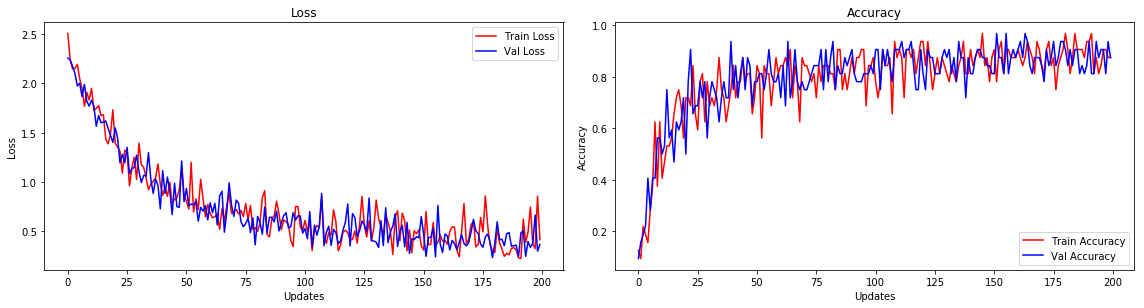

INFO:tensorflow:Restoring parameters from trained_network


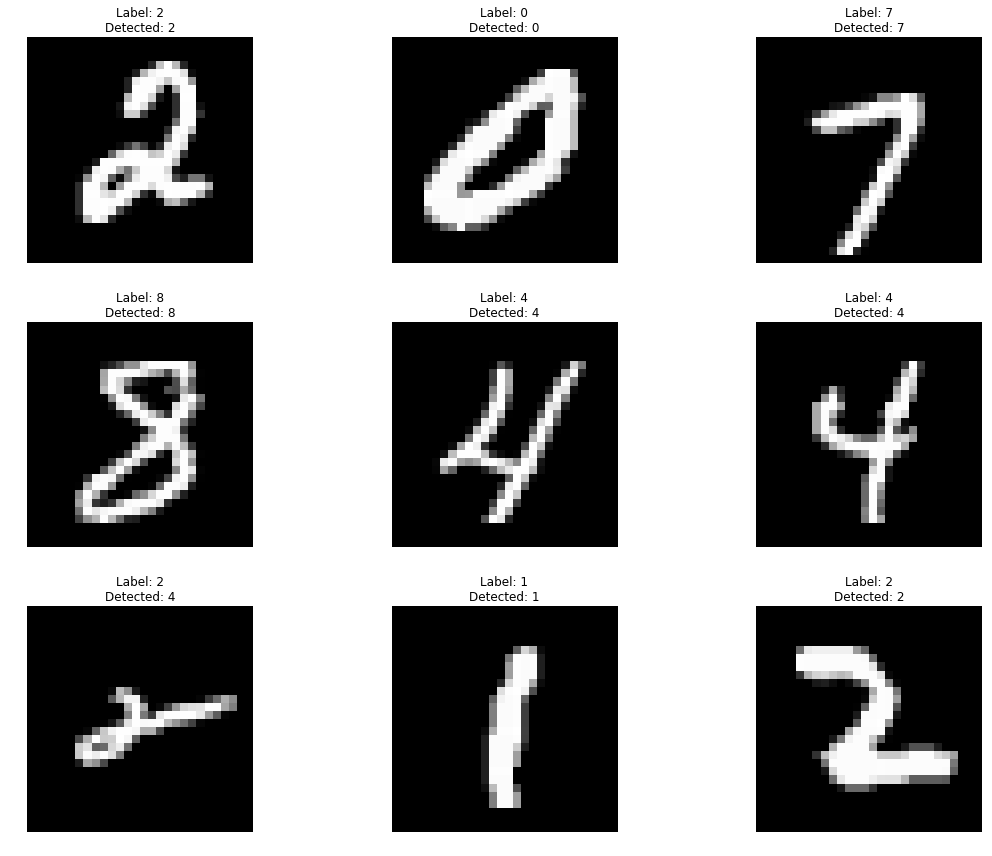

Done


In [60]:
### YOUR CODE HERE ###
fig = plt.figure(figsize=(16,12))

# 1) Plot train and validation loss as a function of time
epoch = np.arange(len(train_cost))
fig.add_subplot(321)
plt.title('Loss')
plt.plot(epoch, train_cost,'r', label='Train Loss')
plt.plot(epoch, val_cost,'b', label='Val Loss')
plt.legend()
plt.xlabel('Updates'), plt.ylabel('Loss')

# 2) Plot train and validation accuracy as a function of time
fig.add_subplot(322)
plt.title('Accuracy')
plt.plot(epoch, train_acc,'r', label='Train Accuracy')
plt.plot(epoch, val_acc,'b', label='Val Accuracy')
plt.legend(loc=4)
plt.xlabel('Updates'), plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# 3) Select some random validation images, visualize them, and examine the output of the network.
from random import randint
nb_valid = 10
plot_nbr = 331
img_idx = []
for i in range(0, nb_valid-1):
    img_idx += [randint(0, mnist_data.validation.num_examples)]
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    try:
        saver.restore(sess, 'trained_network')
        #Compute prediction for this digit image:
        x = mnist_data.validation.images[img_idx]
        feed_dict = {x_pl : x}
        res = sess.run(fetches=y_out, feed_dict=feed_dict)
        
        fig = plt.figure(figsize=(16,12))
        for i in range(0, nb_valid-1):
            #The digit is the arry value with the biggest 
            detected_digit = res[i].argmax()
            fig.add_subplot(plot_nbr)
            #plt.figure(figsize=(2,2))
            plt.axis('off')
            plt.title('Label: %i\nDetected: %i' %(mnist_data.validation.labels[img_idx[i]].argmax(), detected_digit))
            plt.imshow(mnist_data.validation.images[img_idx[i]].reshape(28, 28), cmap='gray')
            plot_nbr += 1
    
    except KeyboardInterrupt:
        print('KeyboardInterrupt')

plt.tight_layout()
plt.show()

print('Done')

# Closing Remarks

You have now seen several different ways in which feed forward neural networks can be created.
There is no "right" way to define a neural network.
Ideally you should be able to understand how to implement everything at a low-level, and use high-level APIs to reduce human error and speedup development.
There are numerous frameworks which takes care the fundamental concepts are implemented correctly.
In this class we will mostly use Tensorflow and show Keras implementations here and there.
There are however alternatives that each have their strenghts and weaknesses: 
- [Pytorch](http://pytorch.org/)
- [Theano](http://deeplearning.net/software/theano/)
- [CNTK](https://github.com/Microsoft/CNTK)
- [Chainer](https://github.com/chainer/chainer)
- ... etc.

There is no framework that is "better" than the others.
However, each has their particular focus.
Keras tries to be the easiest to use and takes the most "High-level" approach to Deep Learning.
This might be useful at times, however, at others you might want to have more flexibility than such a High-level framework can provide. 

As you will see, FFNs are just one of many types of architectures and from here we will take a look at the extremely useful alternative called Convolutional Neural Networks. 

# Book Exercise

- Learning with gradient descent - Exercise 3

Starting with Equation (22) :

$$ a' = \sigma (wa + b) $$

We use the component representation, using the matrix product :

$$ (wa + b)_i = \sum_j(w_{ij}a_j) + b_i $$

Then, as $\sigma(x) = \frac{1}{1 + e^{-x}}$, we have :

$$ a' = \frac{1}{1 + e^{-(\sum_j(w_j a_j) + b)}} $$

So :

$$ a' = \frac{1}{1 + e^{-\sum_j w_j a_j - b}} $$

Where a is the vector of activations from the previous layer, noted as $x_j$ in Equation (4)
